In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max.rows', 150)
pd.set_option('display.max.columns', 150)

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
from xgboost import XGBRegressor

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial
from tqdm import tqdm_notebook as tqdm

from category_encoders import OrdinalEncoder, OneHotEncoder
# import eli5
# from eli5.sklearn import PermutationImportance

from scipy.stats import randint, uniform

In [2]:
from functools import reduce

In [83]:
plt.rcParams['figure.figsize'] = [30, 50]

In [3]:
train = pd.read_csv(f'./data/train.csv')
test = pd.read_csv(f'./data/test.csv')
trn_ob = pd.read_csv(f'./data/train_ob_charges.csv')  # open bab
tst_ob = pd.read_csv(f'./data/test_ob_charges.csv')   # open bab
trn_geom = pd.read_csv(f'./data/train_geom.csv')
tst_geom = pd.read_csv(f'./data/test_geom.csv')
dipole_moments = pd.read_csv(f'./data/dipole_moments.csv')
mulliken_charges = pd.read_csv(f'./data/mulliken_charges.csv')
potential_energy = pd.read_csv(f'./data/potential_energy.csv')
structures = pd.read_csv(f'./data/structures.csv')

## Reduce Memory Function

In [4]:
def reduce_mem_usage(df, verbose=True):
    """
    This function reduces the numeric to the least possible numeric type that fits the data so 
    memory usage during transforming and training will be reduced.
    Taken from: https://www.kaggle.com/todnewman/keras-neural-net-for-champs
    
    Han
    Parameters:
    ===========
    dataframe: input dataframe 
    verbose: verbose mode, default True.
    Output:
    ===========
    dataframe: dataframe with numeric columns types changed to the least possible size
    """

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Create features on structures

In [5]:
# %%time
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

atoms = structures['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

structures['EN'] = atoms_en
structures['rad'] = atoms_rad

i_atom = structures['atom_index'].values
p = structures[['x', 'y', 'z']].values
p_compare = p
m = structures['molecule_name'].values
m_compare = m
r = structures['rad'].values
r_compare = r

source_row = np.arange(len(structures))
max_atoms = 28

bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

print('Calculating bonds')

for i in tqdm(range(max_atoms-1)):
    p_compare = np.roll(p_compare, -1, axis=0)
    m_compare = np.roll(m_compare, -1, axis=0)
    r_compare = np.roll(r_compare, -1, axis=0)
    
    mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
    dists = np.linalg.norm(p - p_compare, axis=1) * mask
    r_bond = r + r_compare
    
    bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)
    
    source_row = source_row
    target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write to dummy row
    
    source_atom = i_atom
    target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col
    
    bonds[(source_row, target_atom)] = bond
    bonds[(target_row, source_atom)] = bond
    bond_dists[(source_row, target_atom)] = dists
    bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

print('Counting and condensing bonds')

bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
n_bonds = [len(x) for x in bonds_numeric]

bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean }
bond_df = pd.DataFrame(bond_data)
structures = structures.join(bond_df)
display(structures.head(20))

{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}



Calculating bonds



Counting and condensing bonds


,molecule_name,atom_index,atom,x,y,z,EN,rad,n_bonds,bond_lengths_mean
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,2.20,0.43,1,1.091953
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,2.20,0.43,1,1.091952
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,2.20,0.43,1,1.091946
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,2.20,0.43,1,1.091948
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564,3.04,0.80,3,1.017195
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377,2.20,0.43,1,1.017190
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758,2.20,0.43,1,1.017187
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543,2.20,0.43,1,1.017208
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602,3.44,0.78,2,0.962107


In [6]:
trn_geom.drop(['id', 'scalar_coupling_constant', 'num_atoms', 'type'], axis=1, inplace=True)

In [7]:
trn_geom.head()

,molecule_name,atom_index_0,atom_index_1,flatness_metric,bond_angle_plane,bond_angle_axis
0,dsgdb9nsd_000001,1,0,0.443763,52.084336,34.460723
1,dsgdb9nsd_000001,1,2,0.443763,73.351369,0.804151
2,dsgdb9nsd_000001,1,3,0.443763,39.073646,44.696643
3,dsgdb9nsd_000001,1,4,0.443763,20.124275,44.160491
4,dsgdb9nsd_000001,2,0,0.443763,50.858953,36.069061


In [8]:
tst_geom.drop(['id', 'num_atoms', 'type'], axis=1, inplace=True)

In [9]:
tst_geom.head()

,molecule_name,atom_index_0,atom_index_1,flatness_metric,bond_angle_plane,bond_angle_axis
0,dsgdb9nsd_000004,2,0,0.0,0.0,90.0
1,dsgdb9nsd_000004,2,1,0.0,0.0,90.0
2,dsgdb9nsd_000004,2,3,0.0,0.0,90.0
3,dsgdb9nsd_000004,3,0,0.0,0.0,90.0
4,dsgdb9nsd_000004,3,1,0.0,0.0,90.0


In [10]:
structures.head()

,molecule_name,atom_index,atom,x,y,z,EN,rad,n_bonds,bond_lengths_mean
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,2.20,0.43,1,1.091953
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,2.20,0.43,1,1.091952
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,2.20,0.43,1,1.091946
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,2.20,0.43,1,1.091948


In [11]:
trn_ob.drop(['Unnamed: 0', 'error'], axis=1, inplace=True)

In [12]:
tst_ob.drop(['Unnamed: 0', 'error'], axis=1, inplace=True)

In [13]:
trn_ob.head(10)

,molecule_name,atom_index,eem,mmff94,gasteiger,qeq,qtpie,eem2015ha,eem2015hm,eem2015hn,eem2015ba,eem2015bm,eem2015bn
0,dsgdb9nsd_000001,0,-0.644531,0.00,-0.077596,3.251140,-3.093807,0.014606,-0.813021,-0.784944,-0.067349,-0.806339,-0.851258
1,dsgdb9nsd_000001,1,0.161131,0.00,0.019399,-0.812772,0.773439,-0.003651,0.203254,0.196234,0.016837,0.201583,0.212813
2,dsgdb9nsd_000001,2,0.161132,0.00,0.019399,-0.812776,0.773442,-0.003651,0.203254,0.196235,0.016837,0.201584,0.212813
3,dsgdb9nsd_000001,3,0.161134,0.00,0.019399,-0.812797,0.773463,-0.003651,0.203256,0.196237,0.016837,0.201586,0.212816
4,dsgdb9nsd_000001,4,0.161134,0.00,0.019399,-0.812795,0.773462,-0.003651,0.203256,0.196237,0.016837,0.201586,0.212816
5,dsgdb9nsd_000002,0,-0.931923,-1.08,-0.451940,2.150686,-1.928544,-1.088976,-1.089901,-0.888107,-0.965422,-0.974099,-0.856768
6,dsgdb9nsd_000002,1,0.310640,0.36,0.150647,-0.716872,0.642826,0.362990,0.363299,0.296034,0.321806,0.324699,0.285588
7,dsgdb9nsd_000002,2,0.310641,0.36,0.150647,-0.716873,0.642828,0.362992,0.363300,0.296035,0.321807,0.324699,0.285589
8,dsgdb9nsd_000002,3,0.310643,0.36,0.150647,-0.716941,0.642891,0.362994,0.363302,0.296037,0.321809,0.324701,0.285591
9,dsgdb9nsd_000003,0,-0.636727,-0.86,-0.576388,1.742329,-1.420778,-0.984997,-0.804795,-0.859773,-0.928456,-0.688535,-0.841479


In [14]:
print('====', len(structures), len(trn_ob)+len(tst_ob), len(trn_ob), len(tst_ob))

==== 2358657 2358657 1533537 825120


In [15]:
structures_train = pd.merge(structures, trn_ob, on=['molecule_name', 'atom_index'])
structures_test = pd.merge(structures, tst_ob, on=['molecule_name', 'atom_index'])

In [16]:
len(structures_test)

825120

In [17]:
structures_train.head()

,molecule_name,atom_index,atom,x,y,z,EN,rad,n_bonds,bond_lengths_mean,eem,mmff94,gasteiger,qeq,qtpie,eem2015ha,eem2015hm,eem2015hn,eem2015ba,eem2015bm,eem2015bn
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,-0.644531,0.0,-0.077596,3.251140,-3.093807,0.014606,-0.813021,-0.784944,-0.067349,-0.806339,-0.851258
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,2.20,0.43,1,1.091953,0.161131,0.0,0.019399,-0.812772,0.773439,-0.003651,0.203254,0.196234,0.016837,0.201583,0.212813
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,2.20,0.43,1,1.091952,0.161132,0.0,0.019399,-0.812776,0.773442,-0.003651,0.203254,0.196235,0.016837,0.201584,0.212813
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,2.20,0.43,1,1.091946,0.161134,0.0,0.019399,-0.812797,0.773463,-0.003651,0.203256,0.196237,0.016837,0.201586,0.212816
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,2.20,0.43,1,1.091948,0.161134,0.0,0.019399,-0.812795,0.773462,-0.003651,0.203256,0.196237,0.016837,0.201586,0.212816


In [18]:
trn_ob.columns

Index(['molecule_name', 'atom_index', 'eem', 'mmff94', 'gasteiger', 'qeq',
       'qtpie', 'eem2015ha', 'eem2015hm', 'eem2015hn', 'eem2015ba',
       'eem2015bm', 'eem2015bn'],
      dtype='object')

## Merge structures function

In [19]:
def merge_train_structures(train, structures, dip_mom, pot_energ, train_geom):
  
    """This function is used to merge the structures dataset to the 
     original train dataset

     Parameters:
     ===========
       train: train dataframe
       structures: structures dataframe.

     Output:
       ===========
       dataframe: merged dataframe
     """

    structures = structures.rename({'atom_index': 'atom_index_0',
                                    'x':'x_0', 'y':'y_0', 'z':'z_0', 'atom':'atom_0',
                                    'eem':'eem_0', 'mmff94':'mmff94_0', 'gasteiger':'gasteiger_0', 
                                    'qeq':'qeq_0', 'qtpie':'qtpie_0', 'eem2015ha':'eem2015ha_0', 
                                    'eem2015hm':'eem2015hm_0', 'eem2015hn':'eem2015hn_0', 'eem2015ba':'eem2015ba_0',
                                    'eem2015bm':'eem2015bm_0', 'eem2015bn':'eem2015bn_0'}, axis=1)

    merged = pd.merge(train, structures, on=['molecule_name', 'atom_index_0'])

    structures = structures.rename({'atom_index_0': 'atom_index_1',
                                    'x_0':'x_1', 'y_0':'y_1', 'z_0':'z_1', 'atom_0':'atom_1',
                                    'eem_0':'eem_1', 'mmff94_0':'mmff94_1', 'gasteiger_0':'gasteiger_1', 
                                    'qeq_0':'qeq_1', 'qtpie_0':'qtpie_1', 'eem2015ha_0':'eem2015ha_1', 
                                    'eem2015hm_0':'eem2015hm_1', 'eem2015hn_0':'eem2015hn_1', 'eem2015ba_0':'eem2015ba_1',
                                    'eem2015bm_0':'eem2015bm_1', 'eem2015bn_0':'eem2015bn_1'}, axis=1)

    merged_1 = pd.merge(merged, structures, on=['molecule_name', 'atom_index_1'])

    structures = structures.rename({'atom_index_1': 'atom_index',
                                  'x_1':'x', 'y_1':'y', 'z_1':'z',
                                  'atom_1':'atom'}, axis=1)
    
    dip_mom = dip_mom.rename({'X':'X_dipm', 'Y':'Y_dipm', 'Z':'Z_dipm'}, axis=1)

    merged_2 = pd.merge(merged_1, dip_mom, on=['molecule_name',])
    merged_3 = pd.merge(merged_2, pot_energ, on=['molecule_name',])
    merged_4 = pd.merge(merged_3, train_geom, on=['molecule_name', 'atom_index_0', 'atom_index_1'])
    
    assert train.shape[0] == merged.shape[0]

    return merged_4

In [20]:
merged = merge_train_structures(train, structures_train, dipole_moments, potential_energy, trn_geom)

In [21]:
len(merged) == len(train)

True

In [22]:
merged.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,EN_x,rad_x,n_bonds_x,bond_lengths_mean_x,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1,X_dipm,Y_dipm,Z_dipm,potential_energy,flatness_metric,bond_angle_plane,bond_angle_axis
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,2.2,0.43,1,1.091953,0.161131,0.0,0.019399,-0.812772,0.773439,-0.003651,0.203254,0.196234,0.016837,0.201583,0.212813,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,-0.644531,0.0,-0.077596,3.251140,-3.093807,0.014606,-0.813021,-0.784944,-0.067349,-0.806339,-0.851258,0.0,0.0,0.0,-40.52368,0.443763,52.084336,34.460723
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,2.2,0.43,1,1.091952,0.161132,0.0,0.019399,-0.812776,0.773442,-0.003651,0.203254,0.196235,0.016837,0.201584,0.212813,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,-0.644531,0.0,-0.077596,3.251140,-3.093807,0.014606,-0.813021,-0.784944,-0.067349,-0.806339,-0.851258,0.0,0.0,0.0,-40.52368,0.443763,50.858953,36.069061
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,2.2,0.43,1,1.091946,0.161134,0.0,0.019399,-0.812797,0.773463,-0.003651,0.203256,0.196237,0.016837,0.201586,0.212816,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,-0.644531,0.0,-0.077596,3.251140,-3.093807,0.014606,-0.813021,-0.784944,-0.067349,-0.806339,-0.851258,0.0,0.0,0.0,-40.52368,0.443763,13.909506,35.642808
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,2.2,0.43,1,1.091948,0.161134,0.0,0.019399,-0.812795,0.773462,-0.003651,0.203256,0.196237,0.016837,0.201586,0.212816,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,-0.644531,0.0,-0.077596,3.251140,-3.093807,0.014606,-0.813021,-0.784944,-0.067349,-0.806339,-0.851258,0.0,0.0,0.0,-40.52368,0.443763,13.124757,34.877453
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,2.2,0.43,1,1.091953,0.161131,0.0,0.019399,-0.812772,0.773439,-0.003651,0.203254,0.196234,0.016837,0.201583,0.212813,H,1.011731,1.463751,0.000277,2.20,0.43,1,1.091952,0.161132,0.0,0.019399,-0.812776,0.773442,-0.003651,0.203254,0.196235,0.016837,0.201584,0.212813,0.0,0.0,0.0,-40.52368,0.443763,73.351369,0.804151
5,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,2.2,0.43,1,1.091953,0.161131,0.0,0.019399,-0.812772,0.773439,-0.003651,0.203254,0.196234,0.016837,0.201583,0.212813,H,-0.540815,1.447527,-0.876644,2.20,0.43,1,1.091946,0.161134,0.0,0.019399,-0.812797,0.773463,-0.003651,0.203256,0.196237,0.016837,0.201586,0.212816,0.0,0.0,0.0,-40.52368,0.443763,39.073646,44.696643
6,5,dsgdb9nsd_000001,2,3,2JHH,-11.2541,H,1.011731,1.463751,0.000277,2.2,0.43,1,1.091952,0.161132,0.0,0.019399,-0.812776,0.773442,-0.003651,0.203254,0.196235,0.016837,0.201584,0.212813,H,-0.540815,1.447527,-0.876644,2.20,0.43,1,1.091946,0.161134,0.0,0.019399,-0.812797,0.773463,-0.003651,0.203256,0.196237,0.016837,0.201586,0.212816,0.0,0.0,0.0,-40.52368,0.443763,19.131914,45.838867
7,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,2.2,0.43,1,1.091953,0.161131,0.0,0.019399,-0.812772,0.773439,-0.003651,0.203254,0.196234,0.016837,0.201583,0.212813,H,-0.523814,1.437933,0.906397,2.20,0.43,1,1.091948,0.161134,0.0,0.019399,-0.812795,0.773462,-0.003651,0.203256,0.196237,0.016837,0.201586,0.212816,0.0,0.0,0.0,-40.52368,0.443763,20.124275,44.160491
8,6,dsgdb9nsd_000001,2,4,2JHH,-11.2548,H,1.011731,1.463751,0.000277,2.2,0.43,1,1.091952,0.161132,0.0,0.019399,-0.812776,0.773442,-0.003651,0.203254,0.196235,0.016837,0.201584,0.212813,H,-0.523814,1.437933,0.906397,2.20,0.43,1,1.091948,0.161134,0.0,0.019399,-0.812795,0.773462,-0.003651,0.203256,0.196237,0.016837,0.201586,0.212816,0.0,0.0,0.0,-40.52368,0.443763,37.879673,45.292567
9,8,dsgdb9nsd_000001,3,4,2JH

In [23]:
mulliken = mulliken_charges.rename({'atom_index': 'atom_index_0',
                          'mulliken_charge': 'mulliken_charge_0'}, axis=1)
merged = merged.merge(mulliken, on=['molecule_name', 'atom_index_0'])

mulliken = mulliken.rename({'atom_index_0': 'atom_index_1',
                          'mulliken_charge_0': 'mulliken_charge_1'}, axis=1)
merged = merged.merge(mulliken, on=['molecule_name', 'atom_index_1'])
len(merged) == len(train)

True

## Feature Engineering

In [24]:
%%time
# This block is SPPED UP

train_p_0 = merged[['x_0', 'y_0', 'z_0']].values
train_p_1 = merged[['x_1', 'y_1', 'z_1']].values
# test_p_0 = test[['x_0', 'y_0', 'z_0']].values
# test_p_1 = test[['x_1', 'y_1', 'z_1']].values

merged['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
# test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
assert len(merged) == len(train)

CPU times: user 2.17 s, sys: 1.79 s, total: 3.96 s
Wall time: 1.49 s


In [25]:
external_data_0 = pd.DataFrame(data={
    'atom_0': ['C', 'H', 'N', 'O', 'F'],
    'atom_0_en': [2.55, 2.20, 3.04, 3.44, 3.98],
    'atomic_mass_0': [12.0107, 1.00784, 14.0067, 15.999, 18.9984],
    'valence_electrons_0': [4, 1, 5, 6, 7]
})
external_data_1 = pd.DataFrame(data={
    'atom_1': ['C', 'H', 'N', 'O', 'F'],
    'atom_1_en': [2.55, 2.20, 3.04, 3.44, 3.98],
    'atomic_mass_1': [12.0107, 1.00784, 14.0067, 15.999, 18.9984],
    'valence_electrons_1': [4, 1, 5, 6, 7]
})

def create_features(df):
    df['bond'] = df['type'].str[2:]
    df['j_type'] = df['type'].str[:2]
    df['distance'] = ((df['x_1'].values - df['x_0'].values)**2 + 
                    (df['y_1'].values - df['y_0'].values)**2 + 
                    (df['z_1'].values - df['z_0'].values)**2)** 0.5
    df['mu_0'] = np.sqrt(df['x_0'].values**2 + df['y_0'].values**2 + df['z_0'].values**2)
    df['mu_1'] = np.sqrt(df['x_1'].values**2 + df['y_1'].values**2 + df['z_1'].values**2)
    df = df.merge(external_data_0, on='atom_0', how='left')
    df = df.merge(external_data_1, on='atom_1', how='left')
    df['delta_en'] = (df['atom_0_en'] - df['atom_1_en']).abs()
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df['molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df['molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df['molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df['molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df['molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df['molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df['molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df['molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df['molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df['molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df['molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df['molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df['molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df['molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df['molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df['molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df['molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df['molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df['molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df['molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df['molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df['molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df['molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df['molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df['molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df['molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    
    df = reduce_mem_usage(df)
    return df

In [26]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df

def create_closest(df_train):
    #I apologize for my poor coding skill. Please make the better one.
    df_temp=df_train.loc[:,["molecule_name","atom_index_0","atom_index_1","dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
#     df_temp=pd.concat(objs=[df_temp,df_temp_],axis=0)

    df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df_temp= df_temp[df_temp["min_distance"]==df_temp["dist"]]

    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                     'atom_index_1': 'atom_index_closest',
                                     'distance': 'distance_closest',
                                     'x_1': 'x_closest',
                                     'y_1': 'y_closest',
                                     'z_1': 'z_closest'})

    for atom_idx in [0,1]:
        df_train = map_atom_info(df_train,df_temp, atom_idx)
        df_train = df_train.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                            'distance_closest': f'distance_closest_{atom_idx}',
                                            'x_closest': f'x_closest_{atom_idx}',
                                            'y_closest': f'y_closest_{atom_idx}',
                                            'z_closest': f'z_closest_{atom_idx}'})
    df_train = reduce_mem_usage(df_train)
    return df_train


In [27]:
merged = create_features(merged)
len(merged) == len(train)

Mem. usage decreased to 1039.51 Mb (70.5% reduction)


True

In [28]:
dtrain = create_closest(merged)

Mem. usage decreased to 1123.92 Mb (2.3% reduction)


In [29]:
len(dtrain) == len(train)

True

In [30]:
def add_cos_features(df):
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["dist"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["dist"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["dist"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    df = reduce_mem_usage(df)
    return df
    
merged = add_cos_features(dtrain)

Mem. usage decreased to 1168.34 Mb (0.0% reduction)


In [31]:
len(merged) == len(train)

True

In [32]:
merged.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,EN_x,rad_x,n_bonds_x,bond_lengths_mean_x,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1,X_dipm,Y_dipm,Z_dipm,potential_energy,flatness_metric,bond_angle_plane,bond_angle_axis,mulliken_charge_0,mulliken_charge_1,dist_x,bond,j_type,distance,mu_0,mu_1,atom_0_en,atomic_mass_0,valence_electrons_0,atom_1_en,atomic_mass_1,valence_electrons_1,delta_en,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,atom_index_closest_0,dist_y,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,dist,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,2.199219,0.429932,1,1.091797,0.161133,0.0,0.019394,-0.812988,0.773438,-0.003651,0.203247,0.196289,0.01683,0.201538,0.212769,C,-0.012695,1.085938,0.008003,2.550781,0.819824,4,1.091797,-0.644531,0.0,-0.077576,3.251953,-3.093750,0.014603,-0.812988,-0.785156,-0.067322,-0.806152,-0.851074,0.0,0.0,0.0,-40.53125,0.443848,52.09375,34.468750,0.133911,-0.535645,1.091797,HC,1J,1.091797,0.006702,1.085938,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,4,4,1.358398,0.272949,1.463867,0.377930,1.610352,0.518555,1.474609,1.783203,0.691406,1.632812,1.091797,0.000000,1.000000,1.091797,-0.000003,1.0,1.091797,0.000000,1.0,1.091797,-0.000007,1.0,1.091797,1.091797,-0.000007,1.0,0,1.091797,-0.012695,1.085938,0.008003,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN
1,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,2.199219,0.429932,1,1.091797,0.161133,0.0,0.019394,-0.812988,0.773438,-0.003651,0.203247,0.196289,0.01683,0.201538,0.212769,C,-0.012695,1.085938,0.008003,2.550781,0.819824,4,1.091797,-0.644531,0.0,-0.077576,3.251953,-3.093750,0.014603,-0.812988,-0.785156,-0.067322,-0.806152,-0.851074,0.0,0.0,0.0,-40.53125,0.443848,50.84375,36.062500,0.133911,-0.535645,1.091797,HC,1J,1.091797,1.779297,1.085938,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,3,4,1.324219,0.237915,1.447266,0.361816,1.552734,0.460693,1.421875,1.783203,0.691406,1.632812,1.091797,0.000000,1.000000,1.091797,-0.000002,1.0,1.091797,0.000001,1.0,1.091797,-0.000005,1.0,1.091797,1.091797,-0.000005,1.0,0,1.091797,-0.012695,1.085938,0.008003,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN
2,7,dsgdb9nsd_000001,3,0,1JHC,84.812500,H,-0.541016,1.447266,-0.876465,2.199219,0.429932,1,1.091797,0.161133,0.0,0.019394,-0.812988,0.773438,-0.003651,0.203247,0.196289,0.01683,0.201538,0.212769,C,-0.012695,1.085938,0.008003,2.550781,0.819824,4,1.091797,-0.644531,0.0,-0.077576,3.251953,-3.093750,0.014603,-0.812988,-0.785156,-0.067322,-0.806152,-0.851074,0.0,0.0,0.0,-40.53125,0.443848,13.90625,35.656250,0.133911,-0.535645,1.091797,HC,1J,1.091797,1.776367,1.085938,2.199219,1.0

In [33]:
def add_extra_features(df):
    df['dip_cop_0'] = (3*(df['cos_0']**2)-1) / 2
    df['dip_cop_1'] = (3*(df['cos_1']**2)-1) / 2
    df['dip_cop_0_1'] = (3*(df['cos_0_1']**2)-1) / 2   
    df['dip_cop_plane'] = (3*(df['bond_angle_plane']**2)-1) / 200
    df['dip_cop_axis'] = (3*(df['bond_angle_axis']**2)-1) / 200
    df[['dip_cop_0', 'dip_cop_1', 'dip_cop_0_1']] = df[['dip_cop_0', 'dip_cop_1', 'dip_cop_0_1']].fillna(0)
    
    df = reduce_mem_usage(df)
    return df
    
merged = add_extra_features(merged)

Mem. usage decreased to 1212.76 Mb (0.0% reduction)


In [34]:
drop_feat = [
    'molecule_atom_index_0_dist_std_div',
    'atom_index_closest_1', 'dist', 'x_closest_1',
    'y_closest_1', 'z_closest_1', 'distance_1',
    'cos_0_1', 'cos_0', 'cos_1', 'EN_y', 'n_bonds_x',
    'molecule_atom_index_0_dist_min_diff',
    'molecule_atom_index_0_dist_min_div','rad_y', 'EN_x', 'rad_x',
    'dist_y', 'atom_1_en', 'atom_0_en', 'z_closest_0']

In [35]:
old_feats = merged.columns

In [36]:
len(merged.columns)

118

In [37]:
new_cols = [f for f in old_feats if f not in drop_feat]

In [38]:
len(new_cols)

98

In [39]:
merged_new = merged[new_cols]

In [40]:
merged_new.head(15)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,bond_lengths_mean_x,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,atom_1,x_1,y_1,z_1,n_bonds_y,bond_lengths_mean_y,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1,X_dipm,Y_dipm,Z_dipm,potential_energy,flatness_metric,bond_angle_plane,bond_angle_axis,mulliken_charge_0,mulliken_charge_1,dist_x,bond,j_type,distance,mu_0,mu_1,atomic_mass_0,valence_electrons_0,atomic_mass_1,valence_electrons_1,delta_en,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,atom_index_closest_0,x_closest_0,y_closest_0,distance_0,dip_cop_0,dip_cop_1,dip_cop_0_1,dip_cop_plane,dip_cop_axis
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,1.091797,0.161133,0.000000,0.019394,-0.812988,0.773438,-0.003651,0.203247,0.196289,0.016830,0.201538,0.212769,C,-0.012695,1.085938,0.008003,4,1.091797,-0.644531,0.000000,-0.077576,3.251953,-3.093750,0.014603,-0.812988,-0.785156,-0.067322,-0.806152,-0.851074,0.0000,0.0,0.000000,-40.53125,0.443848,52.093750,34.468750,0.133911,-0.535645,1.091797,HC,1J,1.091797,0.006702,1.085938,1.007812,1,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,4,4,1.358398,0.272949,1.463867,0.377930,1.610352,0.518555,1.474609,1.783203,0.691406,1.632812,1.091797,1.091797,-0.000003,1.0,1.091797,0.000000,1.0,1.091797,-6.675720e-06,1.0,1.091797,1.091797,-0.000007,1.0,0,-0.012695,1.085938,1.091797,0.000000,0.000000,0.000000,40.718750,17.812500
1,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,1.091797,0.161133,0.000000,0.019394,-0.812988,0.773438,-0.003651,0.203247,0.196289,0.016830,0.201538,0.212769,C,-0.012695,1.085938,0.008003,4,1.091797,-0.644531,0.000000,-0.077576,3.251953,-3.093750,0.014603,-0.812988,-0.785156,-0.067322,-0.806152,-0.851074,0.0000,0.0,0.000000,-40.53125,0.443848,50.843750,36.062500,0.133911,-0.535645,1.091797,HC,1J,1.091797,1.779297,1.085938,1.007812,1,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,3,4,1.324219,0.237915,1.447266,0.361816,1.552734,0.460693,1.421875,1.783203,0.691406,1.632812,1.091797,1.091797,-0.000002,1.0,1.091797,0.000001,1.0,1.091797,-5.245209e-06,1.0,1.091797,1.091797,-0.000005,1.0,0,-0.012695,1.085938,1.091797,0.000000,0.000000,0.000000,38.812500,19.515625
2,7,dsgdb9nsd_000001,3,0,1JHC,84.812500,H,-0.541016,1.447266,-0.876465,1.091797,0.161133,0.000000,0.019394,-0.812988,0.773438,-0.003651,0.203247,0.196289,0.016830,0.201538,0.212769,C,-0.012695,1.085938,0.008003,4,1.091797,-0.644531,0.000000,-0.077576,3.251953,-3.093750,0.014603,-0.812988,-0.785156,-0.067322,-0.806152,-0.851074,0.0000,0.0,0.000000,-40.53125,0.443848,13.906250,35.656250,0.133911,-0.535645,1.091797,HC,1J,1.091797,1.776367,1.085938,1.007812,1,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,2,4,1.261719,0.176025,1.437500,0.352051,1.437500,0.345703,1.316406,1.783203,0.691406,1.632812,1.091797,1.091797,0.000003,1.0,1.091797,0.000007,1.0,1.091797,0.000000e+00,1.0,1.091797,1.091797,0.000000,1.0,0,-0.012695,1.085938,1.091797,0.000000,0.000000,0.0000

In [41]:
merged_new = merged_new.fillna(0)

In [42]:
train_dist = pd.read_csv(f'./data/train_distance_data.csv')
# test_dist = pd.read_csv(f'./data/test_distance_data.csv')

In [43]:
train_dist = reduce_mem_usage(train_dist)

Mem. usage decreased to 653.03 Mb (75.2% reduction)


In [44]:
# test_dist = reduce_mem_usage(test_dist)

In [45]:
train_dist.drop(['Unnamed: 0', 'molecule_index', 'scalar_coupling_constant', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1, inplace=True)
# test_dist.drop(['Unnamed: 0', 'molecule_index', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1, inplace=True)

In [46]:
train_dist.head()

,id,atom_index_0,atom_index_1,atom_2,atom_3,atom_4,atom_5,atom_6,x_2,x_3,x_4,x_5,x_6,y_2,y_3,y_4,y_5,y_6,z_2,z_3,z_4,z_5,z_6,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,atom_7,atom_8,atom_9,x_7,x_8,x_9,y_7,y_8,y_9,z_7,z_8,z_9,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,10,1,0,1,1,0,0,0,0.916016,-0.520508,NaN,NaN,NaN,1.358398,1.343750,NaN,NaN,NaN,-0.028763,-0.775391,NaN,NaN,NaN,1.017578,1.618164,1.017578,1.619141,1.017578,1.619141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,2,0,1,1,0,0,0,0.017258,-0.520508,NaN,NaN,NaN,0.012543,1.343750,NaN,NaN,NaN,-0.027374,-0.775391,NaN,NaN,NaN,1.017578,1.618164,1.017578,1.619141,1.017578,1.619141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15,3,0,1,1,0,0,0,0.916016,0.017258,NaN,NaN,NaN,1.358398,0.012543,NaN,NaN,NaN,-0.028763,-0.027374,NaN,NaN,NaN,1.017578,1.619141,1.017578,1.619141,1.017578,1.618164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,97,3,0,1,6,8,1,0,-0.908203,0.046478,1.072266,-0.961426,NaN,1.827148,-0.011742,-0.652344,-0.475098,NaN,0.018921,0.001204,-0.011131,0.008072,NaN,1.007812,1.734375,1.004883,2.050781,1.359375,2.072266,2.548828,2.281250,3.173828,1.208984,2.960938,2.046875,2.302734,1.109375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,101,4,0,1,6,1,8,0,0.825195,0.046478,-0.961426,1.072266,NaN,1.884766,-0.011742,-0.475098,-0.652344,NaN,0.003738,0.001204,0.008072,-0.011131,NaN,1.004883,1.734375,1.007812,2.072266,1.359375,2.050781,2.302734,2.046875,2.960938,1.109375,3.173828,2.281250,2.548828,1.208984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
merged_trn_dist = pd.merge(merged_new, train_dist, on=['id', 'atom_index_0', 'atom_index_1'], how='left')

In [48]:
merged_trn_dist.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,bond_lengths_mean_x,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,atom_1,x_1,y_1,z_1,n_bonds_y,bond_lengths_mean_y,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1,X_dipm,Y_dipm,Z_dipm,potential_energy,flatness_metric,bond_angle_plane,bond_angle_axis,mulliken_charge_0,mulliken_charge_1,dist_x,bond,j_type,distance,mu_0,mu_1,atomic_mass_0,valence_electrons_0,atomic_mass_1,valence_electrons_1,delta_en,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,...,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,atom_index_closest_0,x_closest_0,y_closest_0,distance_0,dip_cop_0,dip_cop_1,dip_cop_0_1,dip_cop_plane,dip_cop_axis,atom_2,atom_3,atom_4,atom_5,atom_6,x_2,x_3,x_4,x_5,x_6,y_2,y_3,y_4,y_5,y_6,z_2,z_3,z_4,z_5,z_6,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,atom_7,atom_8,atom_9,x_7,x_8,x_9,y_7,y_8,y_9,z_7,z_8,z_9,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,1.091797,0.161133,0.0,0.019394,-0.812988,0.773438,-0.003651,0.203247,0.196289,0.01683,0.201538,0.212769,C,-0.012695,1.085938,0.008003,4,1.091797,-0.644531,0.0,-0.077576,3.251953,-3.093750,0.014603,-0.812988,-0.785156,-0.067322,-0.806152,-0.851074,0.0,0.0,0.0,-40.53125,0.443848,52.09375,34.468750,0.133911,-0.535645,1.091797,HC,1J,1.091797,0.006702,1.085938,1.007812,1,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,4,4,1.358398,0.272949,1.463867,0.377930,1.610352,0.518555,1.474609,1.783203,0.691406,1.632812,...,1.091797,1.091797,-0.000007,1.0,0,-0.012695,1.085938,1.091797,0.000000,0.000000,0.000000,40.718750,17.812500,1,1,1,0,0,1.011719,-0.541016,-0.523926,NaN,NaN,1.463867,1.447266,1.437500,NaN,NaN,0.000277,-0.876465,0.906250,NaN,NaN,1.091797,1.783203,1.091797,1.783203,1.091797,1.783203,1.783203,1.091797,1.783203,1.783203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,1.091797,0.161133,0.0,0.019394,-0.812988,0.773438,-0.003651,0.203247,0.196289,0.01683,0.201538,0.212769,C,-0.012695,1.085938,0.008003,4,1.091797,-0.644531,0.0,-0.077576,3.251953,-3.093750,0.014603,-0.812988,-0.785156,-0.067322,-0.806152,-0.851074,0.0,0.0,0.0,-40.53125,0.443848,50.84375,36.062500,0.133911,-0.535645,1.091797,HC,1J,1.091797,1.779297,1.085938,1.007812,1,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,3,4,1.324219,0.237915,1.447266,0.361816,1.552734,0.460693,1.421875,1.783203,0.691406,1.632812,...,1.091797,1.091797,-0.000005,1.0,0,-0.012695,1.085938,1.091797,0.000000,0.000000,0.000000,38.812500,19.515625,1,1,1,0,0,0.002150,-0.523926,-0.541016,NaN,NaN,-0.006031,1.437500,1.447266,NaN,NaN,0.001976,0.906250,-0.876465,NaN,NaN,1.091797,1.783203,1.091797,1.783203,1.091797,1.783203,1.783203,1.091797,1.783203,1.783203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,dsgdb9nsd_000001,3,0,1JHC,84.812500,H,-0.541016,1.447266,-0.876465,1.091797,0.161133,0.0,0.019394,-0.812988,0.773438,-0.003651,0.203247,0.196289,0.01683,0.201538,0.212769,C,-0.012695,1.085938,0.008003,4,1.091797,-0.644531,0.0,-0.077576,3.251953,-3.093750,0.014603,-0.812988,-0.785156,-0.067

In [ ]:
# merged_trn_dist.isna().any()

## Scoring Function

In [49]:
groups = merged['type']

def group_lmae(y_true, y_pred, groups, floor=1e-9):
    maes = (y_true - y_pred).abs().groupby(groups).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

## Splitting

In [50]:
trainval_1JHC = merged_trn_dist[merged_trn_dist['type'] == '1JHC']
trainval_1JHN = merged_trn_dist[merged_trn_dist['type'] == '1JHN']
trainval_2JHH = merged_trn_dist[merged_trn_dist['type'] == '2JHH']
trainval_2JHN = merged_trn_dist[merged_trn_dist['type'] == '2JHN']
trainval_2JHC = merged_trn_dist[merged_trn_dist['type'] == '2JHC']
trainval_3JHH = merged_trn_dist[merged_trn_dist['type'] == '3JHH']
trainval_3JHC = merged_trn_dist[merged_trn_dist['type'] == '3JHC']
trainval_3JHN = merged_trn_dist[merged_trn_dist['type'] == '3JHN']

In [51]:
def split_col_names(lst):
    return reduce(lambda x,y: x+y, [s.split('\t') for s in lst])

In [52]:
cols_to_del_1JHC = ['dip_cop_0	dip_cop_1	dip_cop_0_1', ]

In [53]:
trainval_1JHC.drop(split_col_names(cols_to_del_1JHC), axis=1, inplace=True)

/home/user/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [ ]:
# test_dist.drop(['Unnamed: 0', 'molecule_index', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1, inplace=True)

In [54]:
cols_to_del_1JHN = ['dip_cop_0	dip_cop_1	dip_cop_0_1', 'atom_7	atom_8	atom_9	x_7	x_8	x_9	y_7	y_8	y_9	z_7	z_8	z_9	d_7_0	d_7_1	d_7_2	d_7_3	d_8_0	d_8_1	d_8_2	d_8_3	d_9_0	d_9_1	d_9_2	d_9_3']

In [55]:
trainval_1JHN.drop(split_col_names(cols_to_del_1JHC), axis=1, inplace=True)

In [56]:
cols_to_del_2JHH = ['x_9', 'y_9', 'z_9', 'd_9_0	d_9_1	d_9_2	d_9_3']

In [57]:
trainval_2JHH.drop(split_col_names(cols_to_del_1JHC), axis=1, inplace=True)

In [58]:
cols_to_del_2JHN = ['dip_cop_0	dip_cop_1	dip_cop_0_1', 'x_9', 'y_9', 'z_9', 'd_9_0	d_9_1	d_9_2	d_9_3']

In [59]:
trainval_2JHN.drop(split_col_names(cols_to_del_1JHC), axis=1, inplace=True)

In [60]:
cols_to_del_2JHC = ['dip_cop_0	dip_cop_1	dip_cop_0_1', 'x_9', 'y_9', 'z_9', 'd_9_0	d_9_1	d_9_2	d_9_3']

In [61]:
trainval_2JHC.drop(split_col_names(cols_to_del_1JHC), axis=1, inplace=True)

In [62]:
cols_to_del_3JHH = ['x_9', 'y_9', 'z_9', 'd_9_0	d_9_1	d_9_2	d_9_3']

In [63]:
trainval_3JHH.drop(split_col_names(cols_to_del_1JHC), axis=1, inplace=True)

In [64]:
cols_to_del_3JHC = ['dip_cop_0	dip_cop_1	dip_cop_0_1',]

In [65]:
trainval_3JHC.drop(split_col_names(cols_to_del_1JHC), axis=1, inplace=True)

In [66]:
cols_to_del_3JHN = ['dip_cop_0	dip_cop_1	dip_cop_0_1',]

In [67]:
trainval_3JHN.drop(split_col_names(cols_to_del_1JHC), axis=1, inplace=True)

In [69]:
trainval_1JHC.tail(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,bond_lengths_mean_x,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,atom_1,x_1,y_1,z_1,n_bonds_y,bond_lengths_mean_y,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1,X_dipm,Y_dipm,Z_dipm,potential_energy,flatness_metric,bond_angle_plane,bond_angle_axis,mulliken_charge_0,mulliken_charge_1,dist_x,bond,j_type,distance,mu_0,mu_1,atomic_mass_0,valence_electrons_0,atomic_mass_1,valence_electrons_1,delta_en,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,...,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,atom_index_closest_0,x_closest_0,y_closest_0,distance_0,dip_cop_plane,dip_cop_axis,atom_2,atom_3,atom_4,atom_5,atom_6,x_2,x_3,x_4,x_5,x_6,y_2,y_3,y_4,y_5,y_6,z_2,z_3,z_4,z_5,z_6,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,atom_7,atom_8,atom_9,x_7,x_8,x_9,y_7,y_8,y_9,z_7,z_8,z_9,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
4658063,4658057,dsgdb9nsd_133882,14,5,1JHC,116.1250,H,-1.715820,0.056427,2.037109,1.090820,0.134888,0.000000,0.098999,0.109375,-0.163818,0.037506,0.210693,0.175781,0.047668,0.215454,0.191772,C,-1.087891,-0.091370,1.158203,4,1.427734,0.044464,0.257812,0.051483,-1.021484,0.899414,0.334229,0.001105,0.045929,0.271729,-0.069458,0.000901,-0.371094,-1.243164,0.0,-400.75,0.767578,0.000191,71.250000,0.097961,-0.012283,1.090820,HC,1J,1.090820,2.664062,1.591797,1.007812,1,12.007812,4,0.350098,58,2.619141,1.082031,3.474609,7,5,0.095032,0.186401,1.547852,1.639648,2.650391,1.559570,2.429688,3.431641,2.339844,3.146484,...,1.090820,0.000000e+00,1.0,2.626953,1.082031,-8.460999e-03,0.992188,5,-1.087891,-0.091370,1.089844,-0.005001,76.187500,8,6,6,6,1,-1.421875,0.433105,-0.929688,-0.292236,0.847656,-1.317383,-0.393311,0.748047,-0.651855,-1.245117,0.347168,1.021484,-0.143311,-0.321777,1.554688,1.090820,2.199219,1.507812,2.419922,1.556641,2.179688,2.419922,1.556641,2.179688,2.125000,2.845703,1.771484,1.471680,1.548828,2.916016,2.289062,2.572266,1.087891,1.0,6.0,6.0,-1.817383,0.344482,1.295898,0.987305,1.547852,0.750977,-0.723145,-0.265137,0.548340,2.916016,2.289062,2.572266,3.164062,3.431641,2.601562,3.421875,2.330078,3.431641,2.601562,3.421875,1.508789
4658069,4658069,dsgdb9nsd_133884,9,0,1JHC,103.6250,H,-2.089844,1.407227,1.185547,1.093750,0.138306,0.000000,0.068115,-0.203979,0.150757,0.005077,0.202393,0.176147,0.020813,0.208252,0.193970,C,-1.435547,1.363281,0.311035,4,1.320312,-0.199219,0.209595,-0.016083,0.466797,-0.400879,0.275635,-0.242920,-0.253418,0.186035,-0.292236,-0.314697,1.362305,1.406250,-0.0,-364.75,0.772461,55.625000,33.125000,0.101868,-0.276367,1.093750,HC,1J,1.093750,2.785156,2.003906,1.007812,1,12.007812,4,0.350098,78,2.609375,1.081055,3.601562,7,6,0.685059,-0.678223,2.259766,0.896973,2.371094,1.276367,2.167969,3.601562,2.507812,3.292969,...,1.093750,0.000000e+00,1.0,2.625000,1.081055,-1.229858e-02,0.988770,0,-1.435547,1.363281,1.093750,46.406250,16.453125,1,7,6,6,1,-1.539062,-1.571289,-0.027069,-0.750977,-1.327148,2.259766,0.047943,0.747070,-0.602051,-0.814453,-0.305420,-0.491699,0.478516,0.666016,1.567383,1.093750,1.804688,1.093750,2.220703,1.546875,2.220703,2.277344,1.546875,2.277344,1.953125,2.468750,2.111328,3.123047,1.560547,2.378906,2.515625,3.6

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
train_1JHC, val_1JHC = train_test_split(trainval_1JHC, shuffle=False, random_state=47)

train_1JHC_molecules = train_1JHC['molecule_name'].unique()
val_1JHC_molecules = np.delete(val_1JHC['molecule_name'].unique(), 0)

train_1JHC = train_1JHC[train_1JHC['molecule_name'].isin(train_1JHC_molecules)]
val_1JHC = val_1JHC[val_1JHC['molecule_name'].isin(val_1JHC_molecules)]

###################################

train_1JHN, val_1JHN = train_test_split(trainval_1JHN, shuffle=False, random_state=47)

train_1JHN_molecules = train_1JHN['molecule_name'].unique()
val_1JHN_molecules = np.delete(val_1JHN['molecule_name'].unique(), 0)

train_1JHN = train_1JHN[train_1JHN['molecule_name'].isin(train_1JHN_molecules)]
val_1JHN = val_1JHN[val_1JHN['molecule_name'].isin(val_1JHN_molecules)]

#####################################

train_2JHH, val_2JHH = train_test_split(trainval_2JHH, shuffle=False, random_state=47)

train_2JHH_molecules = train_2JHH['molecule_name'].unique()
val_2JHH_molecules = np.delete(val_2JHH['molecule_name'].unique(), 0)

train_2JHH = train_2JHH[train_2JHH['molecule_name'].isin(train_2JHH_molecules)]
val_2JHH = val_2JHH[val_2JHH['molecule_name'].isin(val_2JHH_molecules)]

###################################

train_2JHN, val_2JHN = train_test_split(trainval_2JHN, shuffle=False, random_state=47)

train_2JHN_molecules = train_2JHN['molecule_name'].unique()
val_2JHN_molecules = np.delete(val_2JHN['molecule_name'].unique(), 0)

train_2JHN = train_2JHN[train_2JHN['molecule_name'].isin(train_2JHN_molecules)]
val_2JHN = val_2JHN[val_2JHN['molecule_name'].isin(val_2JHN_molecules)]

####################################

train_2JHC, val_2JHC = train_test_split(trainval_2JHC, shuffle=False, random_state=47)

train_2JHC_molecules = train_2JHC['molecule_name'].unique()
val_2JHC_molecules = np.delete(val_2JHC['molecule_name'].unique(), 0)

train_2JHC = train_2JHC[train_2JHC['molecule_name'].isin(train_2JHC_molecules)]
val_2JHC = val_2JHC[val_2JHC['molecule_name'].isin(val_2JHC_molecules)]

####################################

train_3JHH, val_3JHH = train_test_split(trainval_3JHH, shuffle=False, random_state=47)

train_3JHH_molecules = train_3JHH['molecule_name'].unique()
val_3JHH_molecules = np.delete(val_3JHH['molecule_name'].unique(), 0)

train_3JHH = train_3JHH[train_3JHH['molecule_name'].isin(train_3JHH_molecules)]
val_3JHH = val_3JHH[val_3JHH['molecule_name'].isin(val_3JHH_molecules)]

#######################################

train_3JHC, val_3JHC = train_test_split(trainval_3JHC, shuffle=False, random_state=47)

train_3JHC_molecules = train_3JHC['molecule_name'].unique()
val_3JHC_molecules = np.delete(val_3JHC['molecule_name'].unique(), 0)

train_3JHC = train_3JHC[train_3JHC['molecule_name'].isin(train_3JHC_molecules)]
val_3JHC = val_3JHC[val_3JHC['molecule_name'].isin(val_3JHC_molecules)]

#######################################

train_3JHN, val_3JHN = train_test_split(trainval_3JHN, shuffle=False, random_state=47)

train_3JHN_molecules = train_3JHN['molecule_name'].unique()
val_3JHN_molecules = np.delete(val_3JHN['molecule_name'].unique(), 0)

train_3JHN = train_3JHN[train_3JHN['molecule_name'].isin(train_3JHN_molecules)]
val_3JHN = val_3JHN[val_3JHN['molecule_name'].isin(val_3JHN_molecules)]

#########################################

In [72]:
target = 'scalar_coupling_constant'

In [73]:
# split data
y_train_1JHC = train_1JHC[target]
y_train_1JHN = train_1JHN[target]
y_train_2JHH = train_2JHH[target]
y_train_2JHN = train_2JHN[target]
y_train_2JHC = train_2JHC[target]
y_train_3JHH = train_3JHH[target]
y_train_3JHC = train_3JHC[target]
y_train_3JHN = train_3JHN[target]

y_val_1JHC = val_1JHC[target]
y_val_1JHN = val_1JHN[target]
y_val_2JHH = val_2JHH[target]
y_val_2JHN = val_2JHN[target]
y_val_2JHC = val_2JHC[target]
y_val_3JHH = val_3JHH[target]
y_val_3JHC = val_3JHC[target]
y_val_3JHN = val_3JHN[target]

X_train_1JHC = train_1JHC.drop([target,], axis=1).fillna(0)
X_train_1JHN = train_1JHN.drop([target,], axis=1).fillna(0)
X_train_2JHH = train_2JHH.drop([target,], axis=1).fillna(0)
X_train_2JHN = train_2JHN.drop([target,], axis=1).fillna(0)
X_train_2JHC = train_2JHC.drop([target,], axis=1).fillna(0)
X_train_3JHH = train_3JHH.drop([target,], axis=1).fillna(0)
X_train_3JHC = train_3JHC.drop([target,], axis=1).fillna(0)
X_train_3JHN = train_3JHN.drop([target,], axis=1).fillna(0)

X_val_1JHC = val_1JHC.drop([target,], axis=1).fillna(0)
X_val_1JHN = val_1JHN.drop([target,], axis=1).fillna(0)
X_val_2JHH = val_2JHH.drop([target,], axis=1).fillna(0)
X_val_2JHN = val_2JHN.drop([target,], axis=1).fillna(0)
X_val_2JHC = val_2JHC.drop([target,], axis=1).fillna(0)
X_val_3JHH = val_3JHH.drop([target,], axis=1).fillna(0)
X_val_3JHC = val_3JHC.drop([target,], axis=1).fillna(0)
X_val_3JHN = val_3JHN.drop([target,], axis=1).fillna(0)

In [74]:
print(len(y_train_1JHC) - len(X_train_1JHC))

0


## Encoding

In [75]:
def encode(df):
  df = OrdinalEncoder.fit_transform(OrdinalEncoder(df), df)
  return df

def imp(df):
  df = SimpleImputer.fit_transform(SimpleImputer(df), df)
  return df

In [76]:
X_train_1JHC_encoded = encode(X_train_1JHC)
X_train_1JHN_encoded = encode(X_train_1JHN)
X_train_2JHH_encoded = encode(X_train_2JHH)
X_train_2JHC_encoded = encode(X_train_2JHC)
X_train_2JHN_encoded = encode(X_train_2JHN)
X_train_3JHH_encoded = encode(X_train_3JHH)
X_train_3JHC_encoded = encode(X_train_3JHC)
X_train_3JHN_encoded = encode(X_train_3JHN)

X_val_1JHC_encoded = encode(X_val_1JHC)
X_val_1JHN_encoded = encode(X_val_1JHN)
X_val_2JHH_encoded = encode(X_val_2JHH)
X_val_2JHN_encoded = encode(X_val_2JHN)
X_val_2JHC_encoded = encode(X_val_2JHC)
X_val_3JHH_encoded = encode(X_val_3JHH)
X_val_3JHC_encoded = encode(X_val_3JHC)
X_val_3JHN_encoded = encode(X_val_3JHN)

In [77]:
X_train_1JHC_encoded.head()

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,bond_lengths_mean_x,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,atom_1,x_1,y_1,z_1,n_bonds_y,bond_lengths_mean_y,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1,X_dipm,Y_dipm,Z_dipm,potential_energy,flatness_metric,bond_angle_plane,bond_angle_axis,mulliken_charge_0,mulliken_charge_1,dist_x,bond,j_type,distance,mu_0,mu_1,atomic_mass_0,valence_electrons_0,atomic_mass_1,valence_electrons_1,delta_en,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,...,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,atom_index_closest_0,x_closest_0,y_closest_0,distance_0,dip_cop_plane,dip_cop_axis,atom_2,atom_3,atom_4,atom_5,atom_6,x_2,x_3,x_4,x_5,x_6,y_2,y_3,y_4,y_5,y_6,z_2,z_3,z_4,z_5,z_6,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,atom_7,atom_8,atom_9,x_7,x_8,x_9,y_7,y_8,y_9,z_7,z_8,z_9,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,0,1,1,0,1,1,0.002150,-0.006031,0.001976,1.091797,0.161133,0.000000,0.019394,-0.812988,0.773438,-0.003651,0.203247,0.196289,0.016830,0.201538,0.212769,1,-0.012695,1.085938,0.008003,4,1.091797,-0.644531,0.000000,-0.077576,3.251953,-3.093750,0.014603,-0.812988,-0.785156,-0.067322,-0.806152,-0.851074,0.0,0.0,0.000000,-40.53125,0.443848,52.09375,34.46875,0.133911,-0.535645,1.091797,1,1,1.091797,0.006702,1.085938,1.007812,1,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,4,4,1.358398,0.272949,1.463867,0.377930,1.610352,0.518555,1.474609,1.783203,0.691406,1.632812,1.091797,...,1.091797,-0.000007,1.0,1.091797,1.091797,-0.000007,1.0,0,-0.012695,1.085938,1.091797,40.718750,17.812500,1,1,1,0,0,1.011719,-0.541016,-0.523926,0.0,0.0,1.463867,1.447266,1.437500,0.0,0.0,0.000277,-0.876465,0.906250,0.0,0.0,1.091797,1.783203,1.091797,1.783203,1.091797,1.783203,1.783203,1.091797,1.783203,1.783203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,1,2,0,1,1,1.011719,1.463867,0.000277,1.091797,0.161133,0.000000,0.019394,-0.812988,0.773438,-0.003651,0.203247,0.196289,0.016830,0.201538,0.212769,1,-0.012695,1.085938,0.008003,4,1.091797,-0.644531,0.000000,-0.077576,3.251953,-3.093750,0.014603,-0.812988,-0.785156,-0.067322,-0.806152,-0.851074,0.0,0.0,0.000000,-40.53125,0.443848,50.84375,36.06250,0.133911,-0.535645,1.091797,1,1,1.091797,1.779297,1.085938,1.007812,1,12.007812,4,0.350098,10,1.506836,1.091797,1.783203,3,4,1.324219,0.237915,1.447266,0.361816,1.552734,0.460693,1.421875,1.783203,0.691406,1.632812,1.091797,...,1.091797,-0.000005,1.0,1.091797,1.091797,-0.000005,1.0,0,-0.012695,1.085938,1.091797,38.812500,19.515625,1,1,1,0,0,0.002150,-0.523926,-0.541016,0.0,0.0,-0.006031,1.437500,1.447266,0.0,0.0,0.001976,0.906250,-0.876465,0.0,0.0,1.091797,1.783203,1.091797,1.783203,1.091797,1.783203,1.783203,1.091797,1.783203,1.783203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,1,3,0,1,1,-0.541016,1.447266,-0.876465,1.091797,0.161133,0.000000,0.019394,-0.812988,0.773438,-0.003651,0.203247,0.196289,0.016830,0.201538,0.212769,1,-0.012695,1.085938,0.008003,4,1.091797,-0.644531,0.000000,-0.077576,3.251953,-3.093

In [79]:
xgb_model_1JHC = XGBRegressor(nthread=7)
# xgb_model = XGBRegressor(gpu_id=0, max_bin=16, tree_method='gpu_hist')

In [81]:
xgb_model_1JHC.fit(X_train_1JHC_encoded, y_train_1JHC)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=7, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

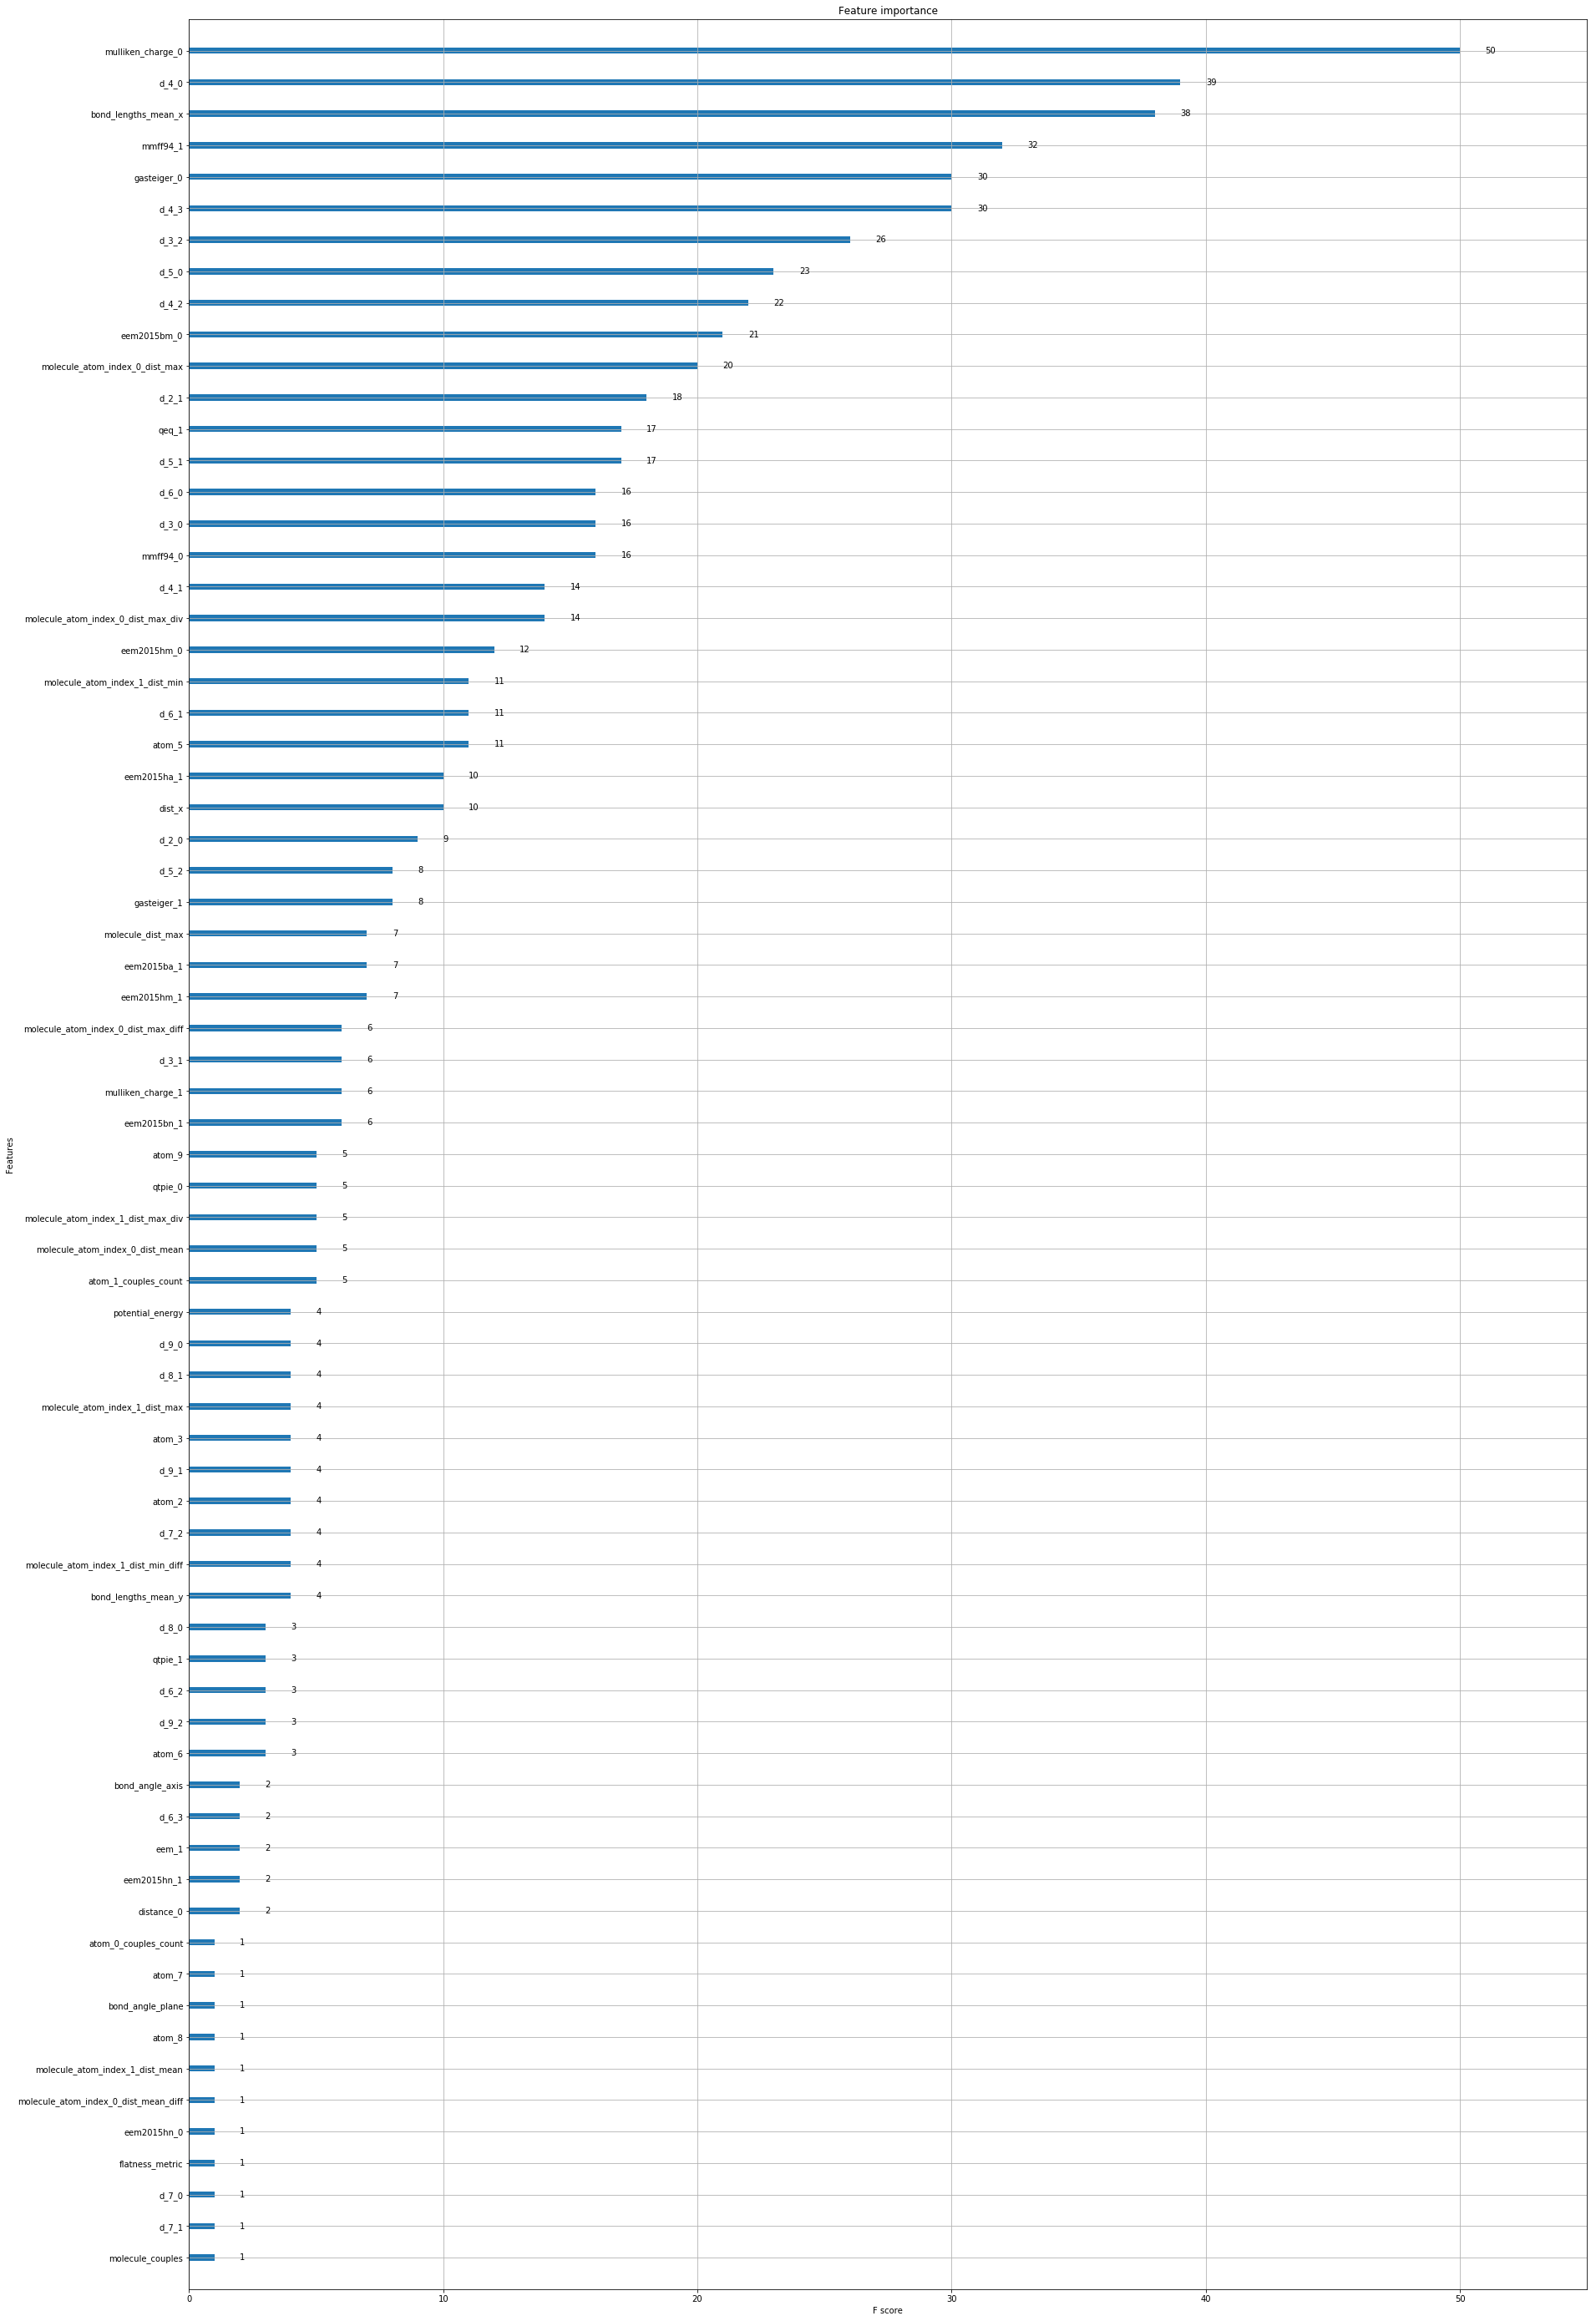

In [84]:
xgb.plot_importance(xgb_model_1JHC)
# plt['figsize'] = [30, 50]
plt.show()

In [85]:
xgb_model_1JHN = XGBRegressor(nthread=7)

In [89]:
xgb_model_1JHN.fit(X_train_1JHN_encoded, y_train_1JHN)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=7, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

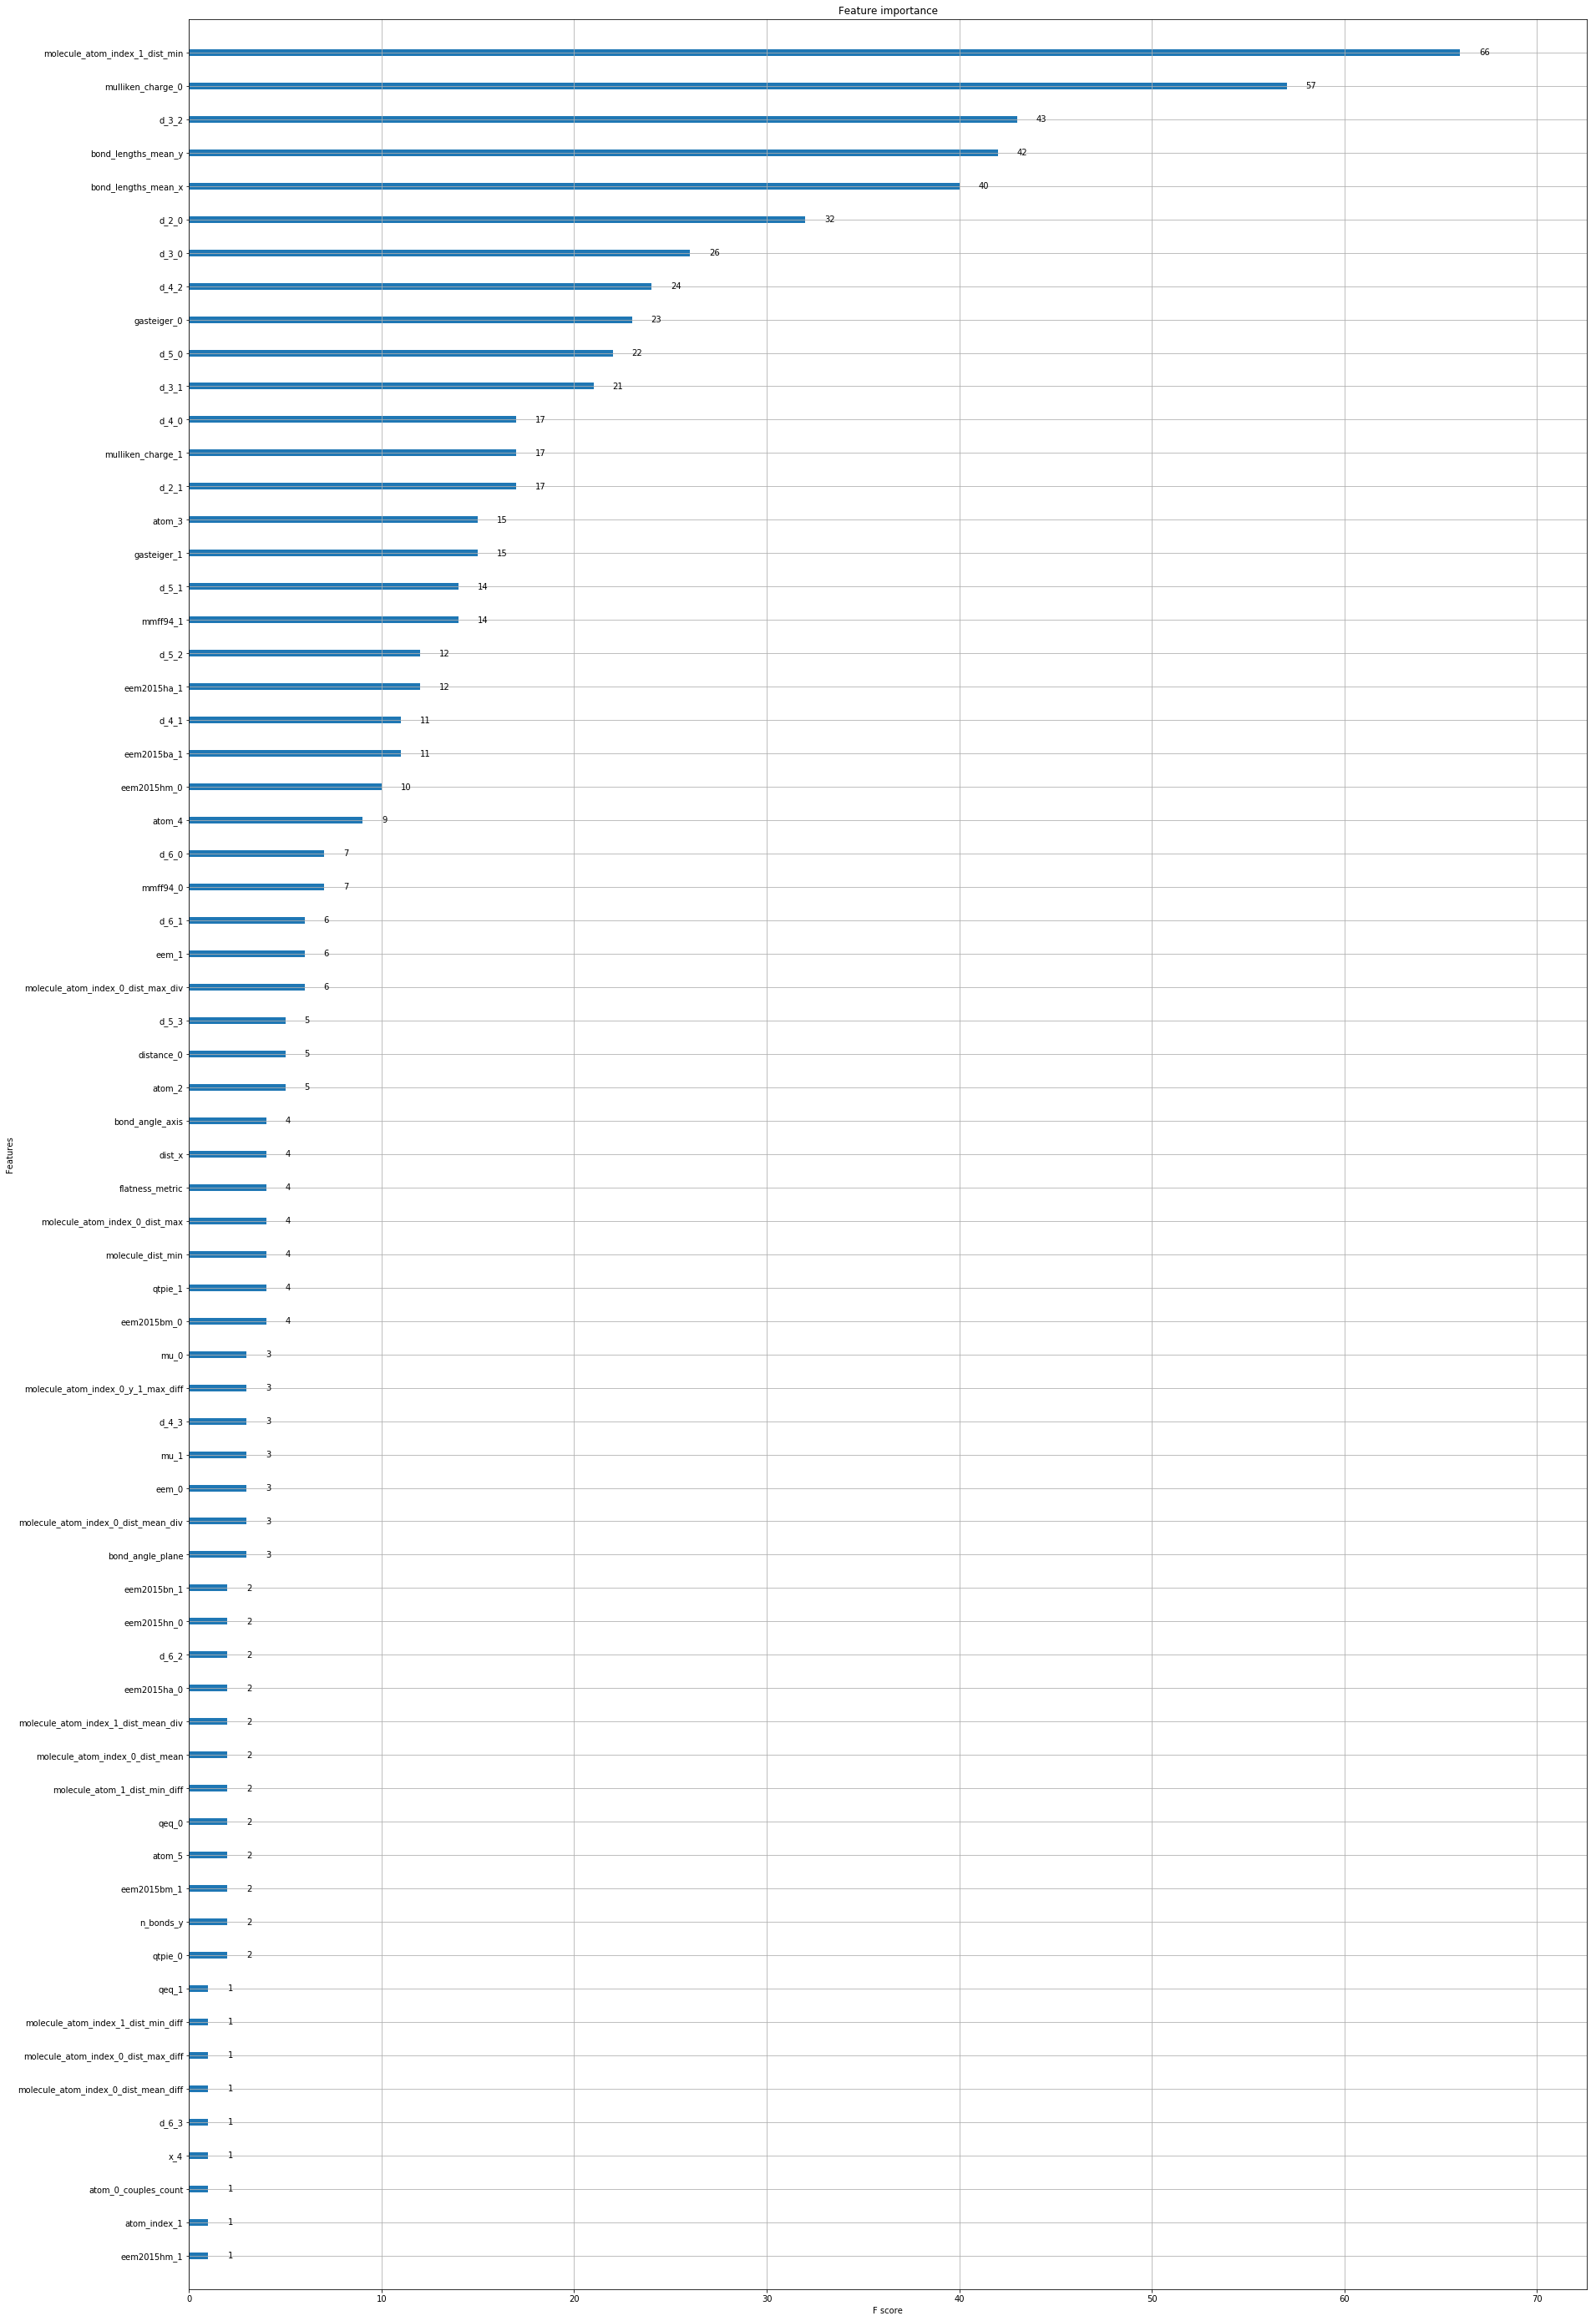

In [90]:
xgb.plot_importance(xgb_model_1JHN)
plt.show()

In [91]:
xgb_model_2JHH = XGBRegressor(nthread=7)

In [92]:
xgb_model_2JHH.fit(X_train_2JHH_encoded, y_train_2JHH)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=7, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

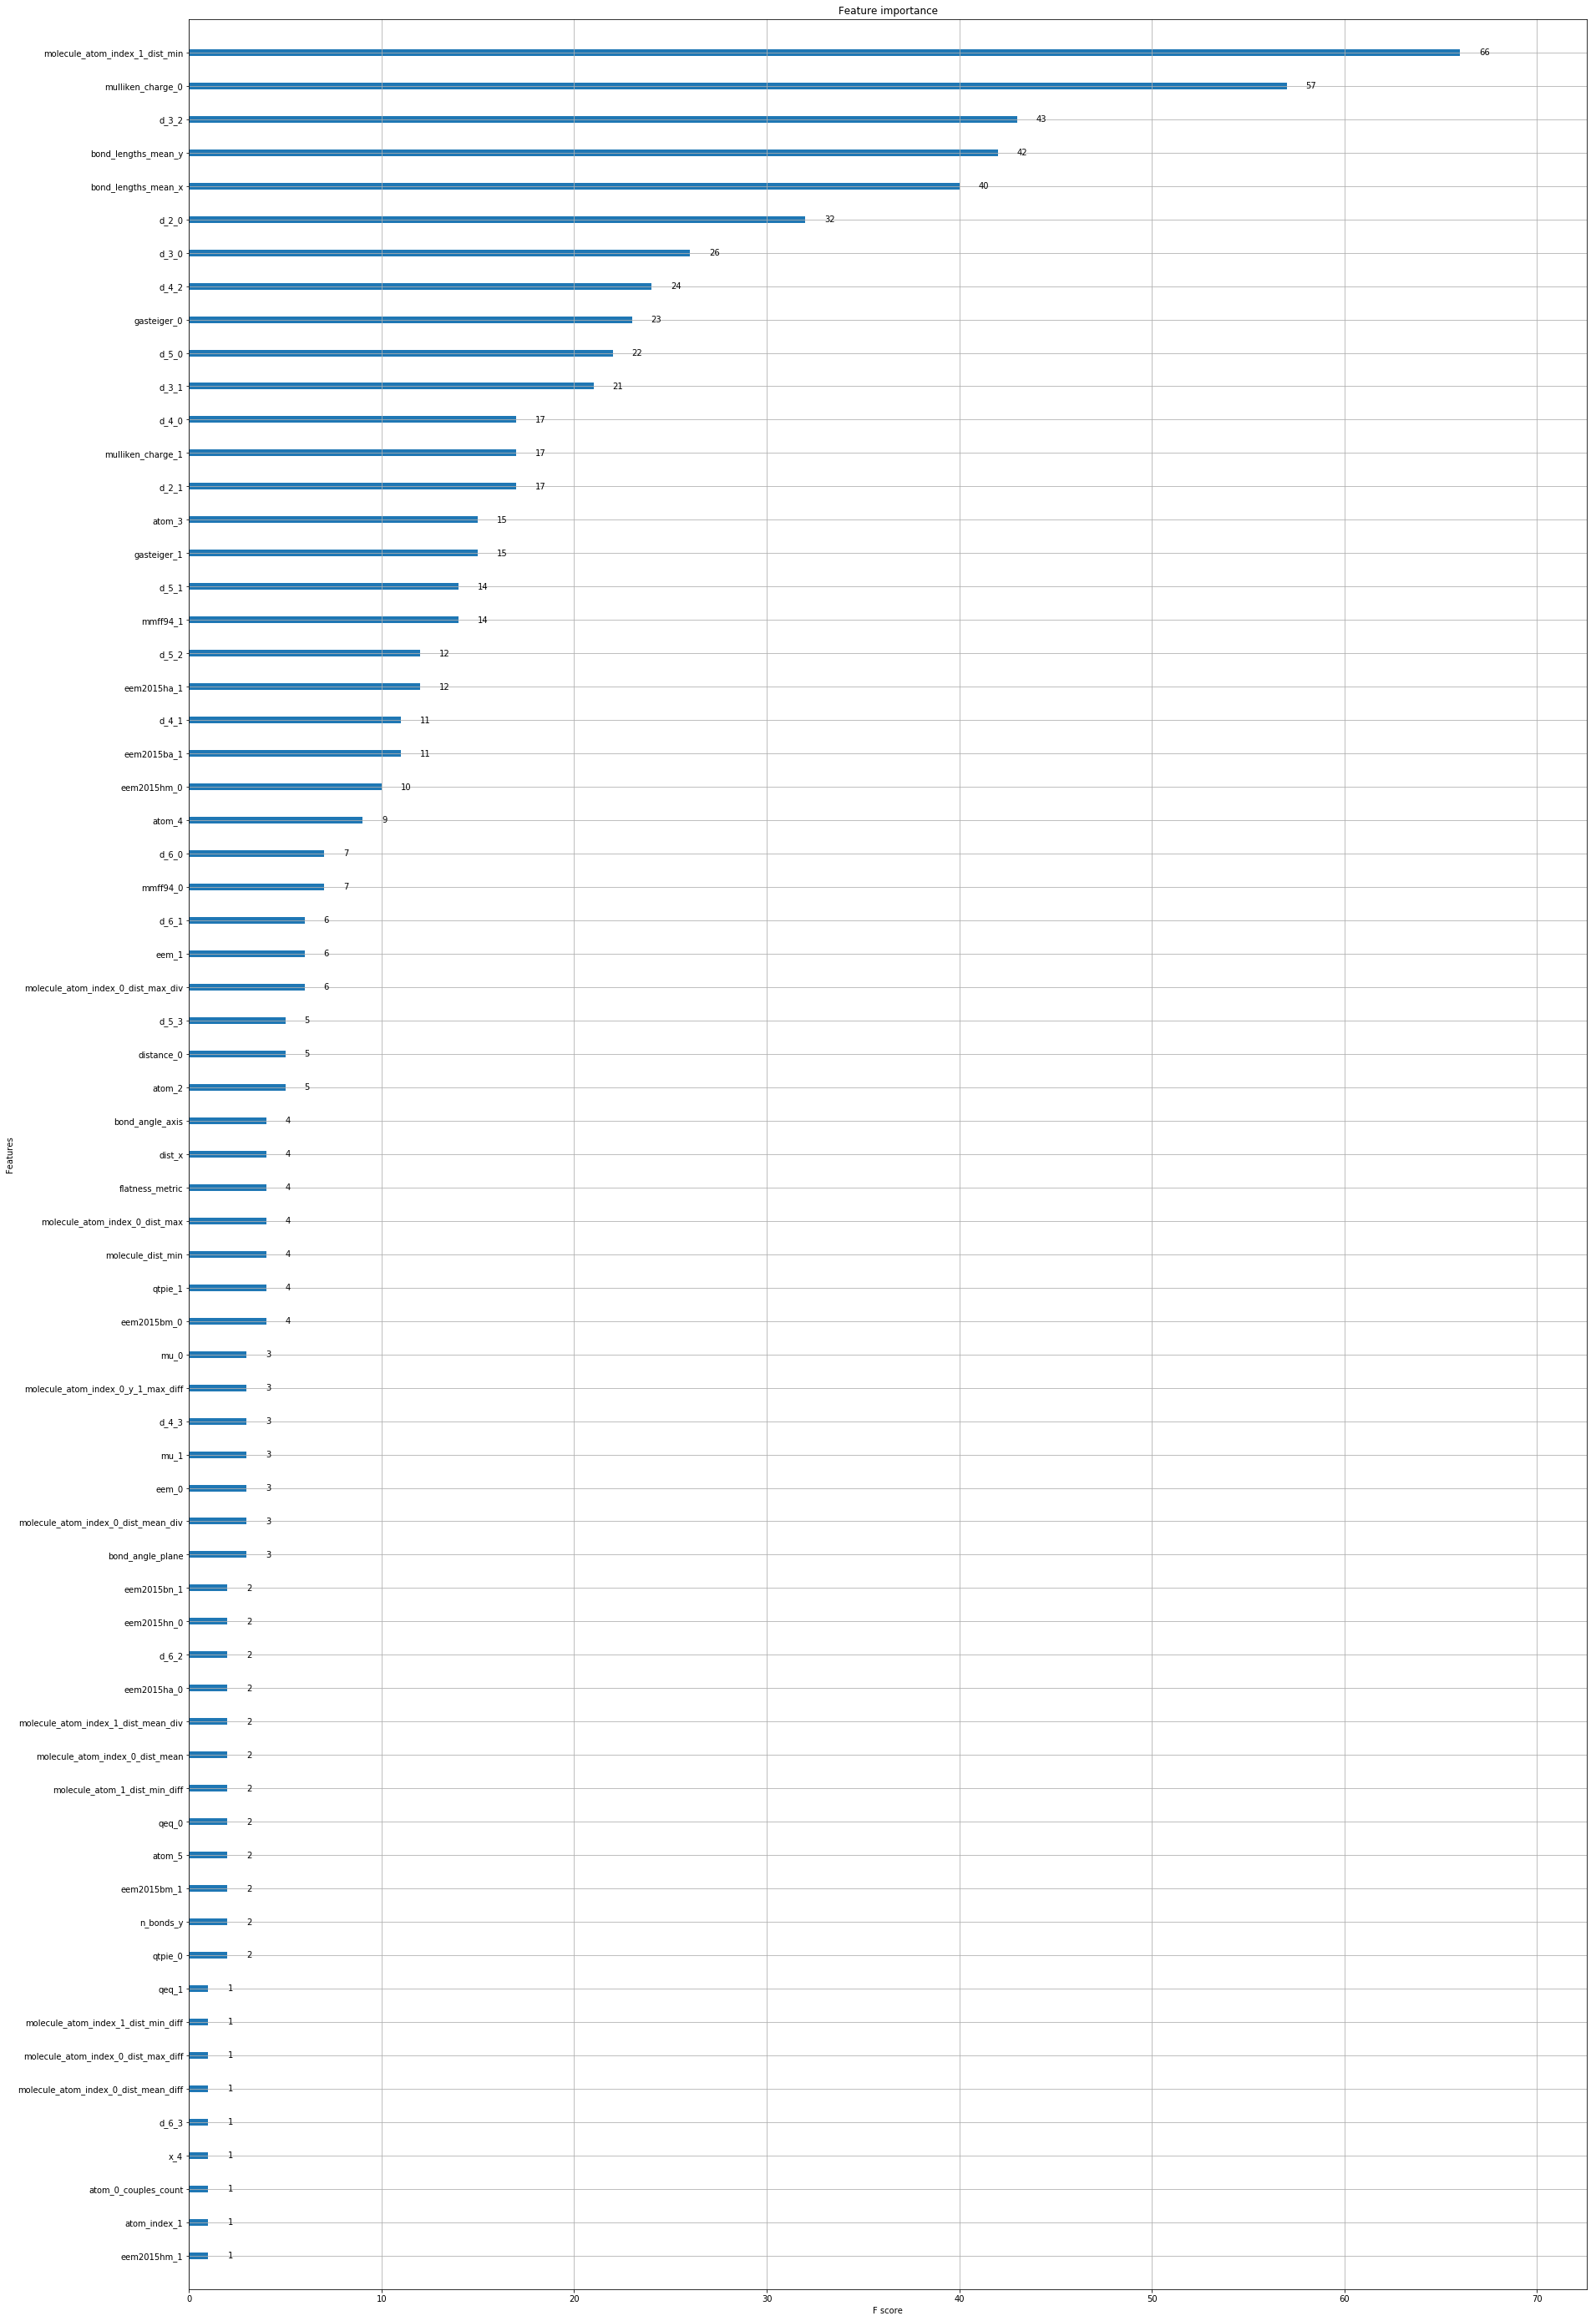

In [93]:
xgb.plot_importance(xgb_model_1JHN)
plt.show()

In [95]:
from catboost import CatBoostRegressor

In [104]:
from catboost import Pool, cv

In [96]:
cat_model_2JHH = CatBoostRegressor(task_type="GPU", devices='0:1')

In [97]:
cat_model_2JHH.fit(X_train_2JHH_encoded, y_train_2JHH, verbose=False)

In [100]:
cat_feats_imp = cat_model_2JHH.get_feature_importance()

In [103]:
categorical_features_indices =[0,1,3,4,5,6,7,8]

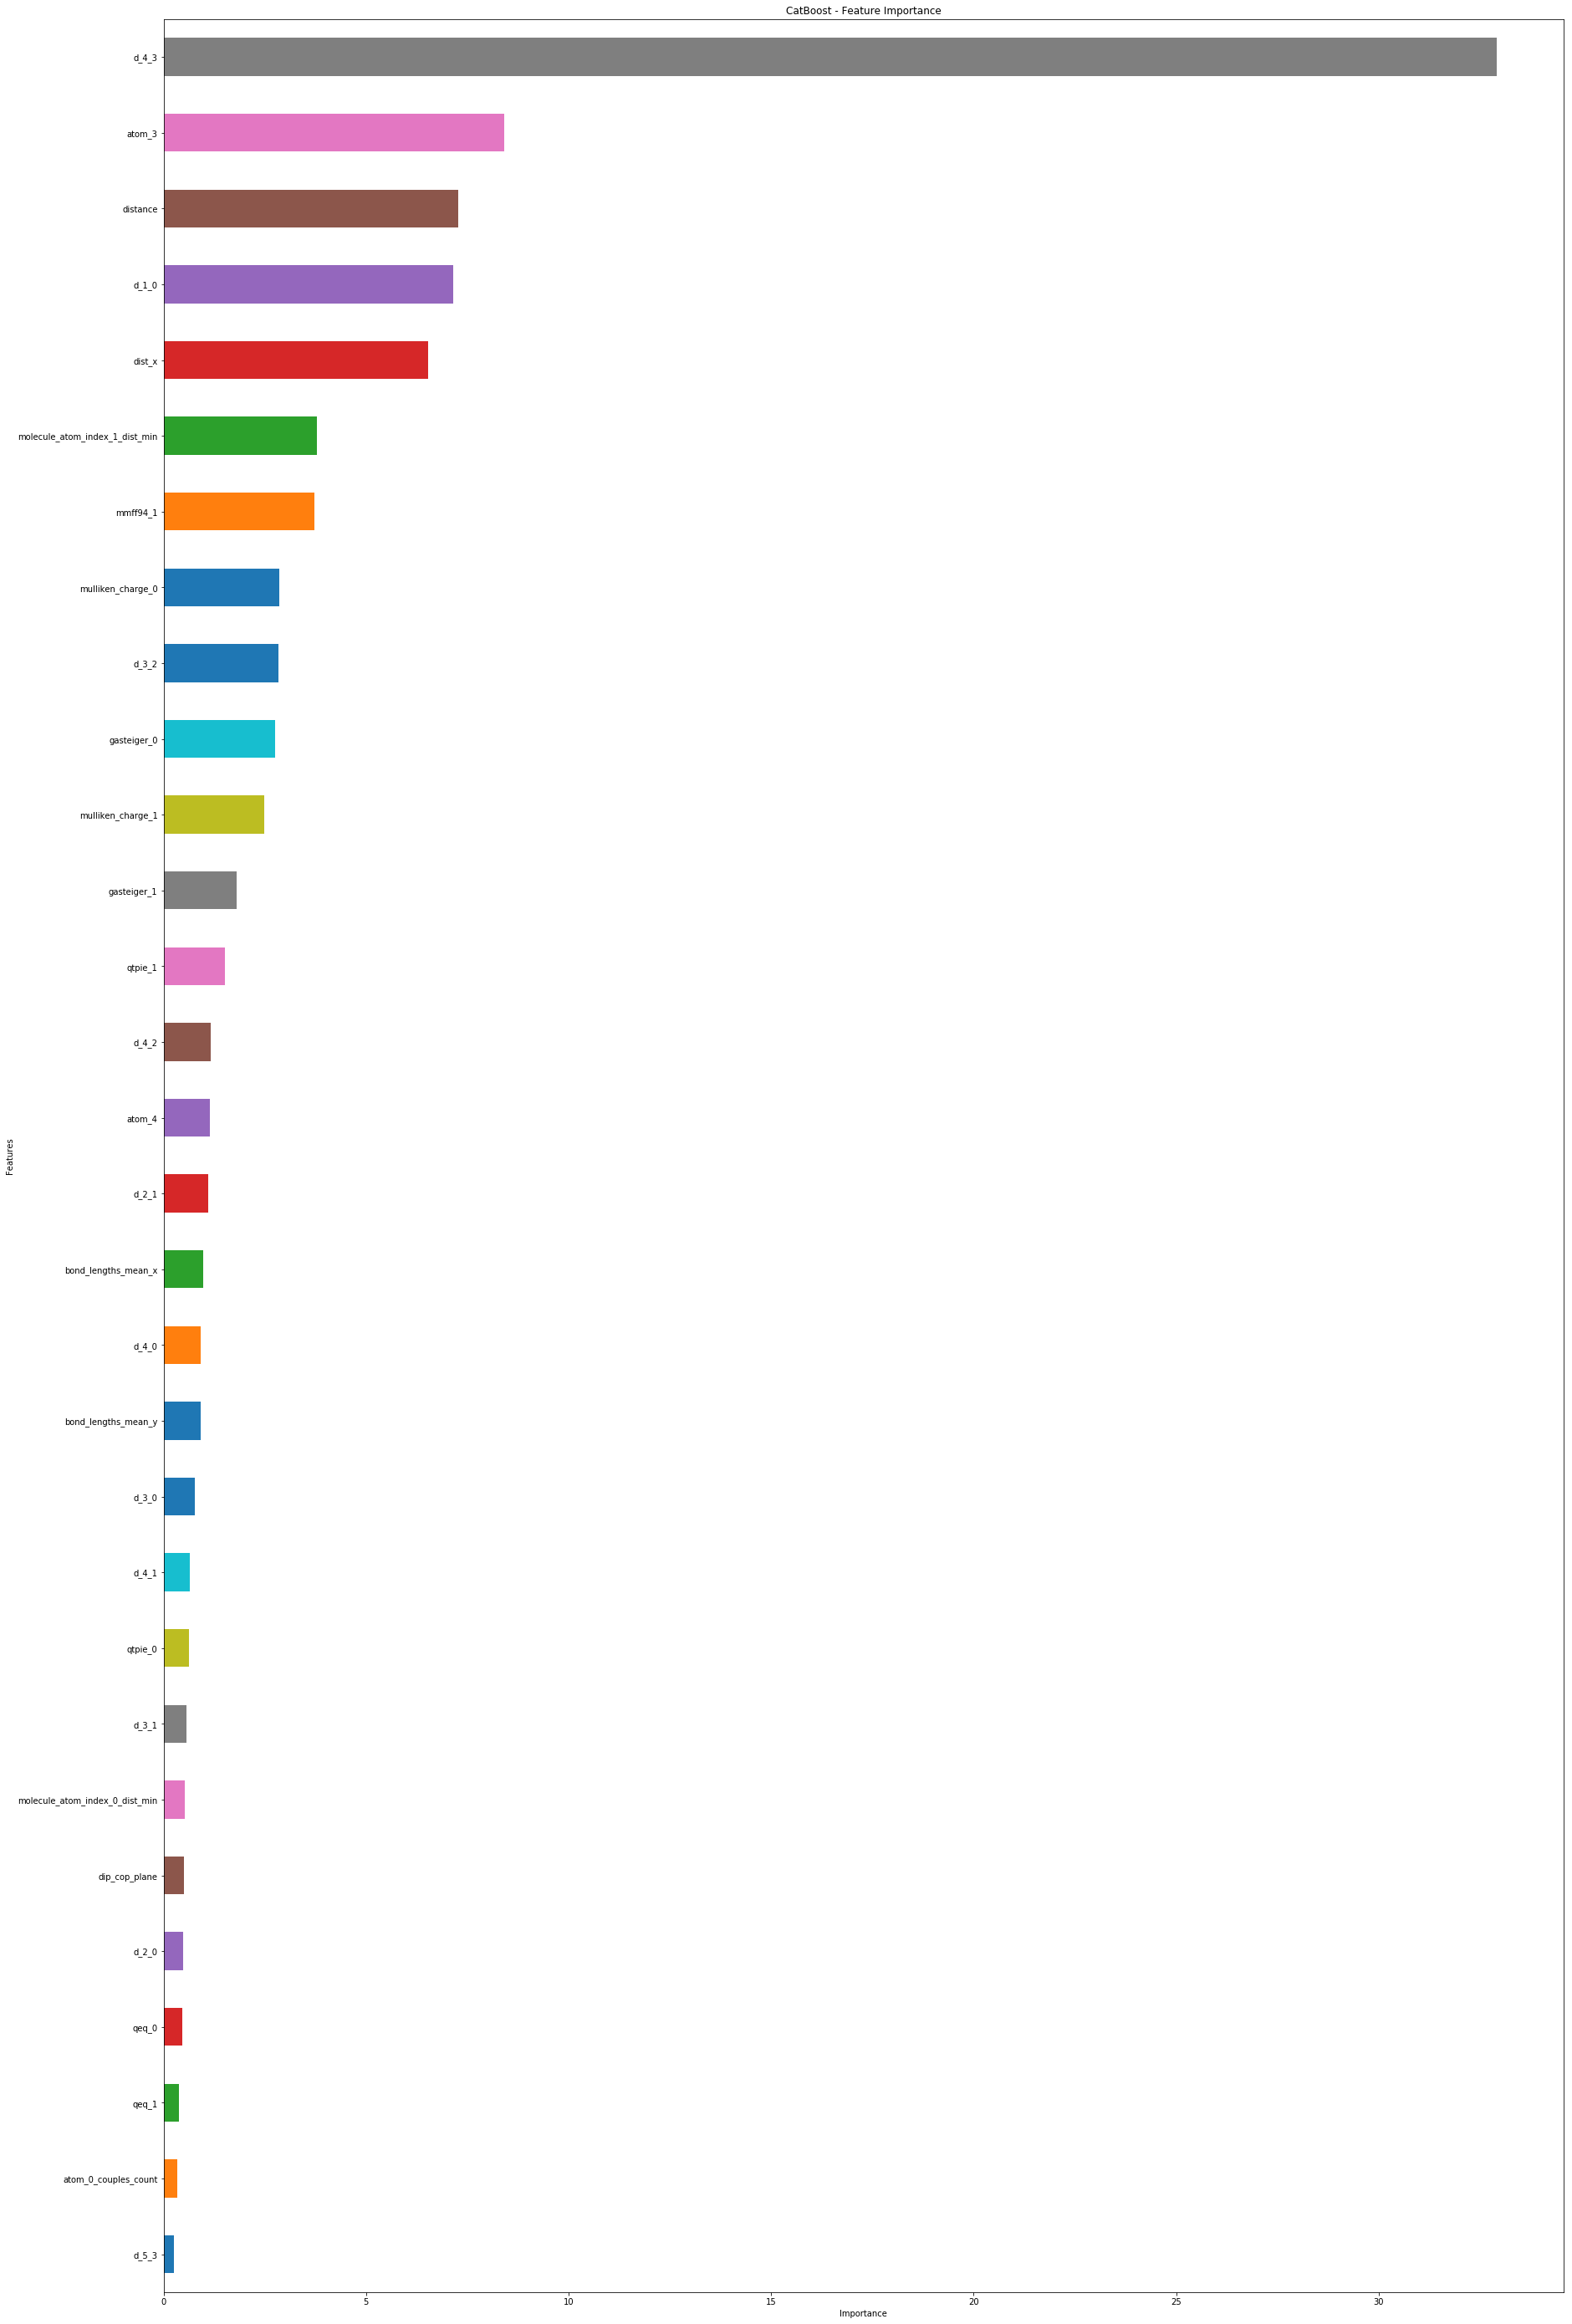

In [107]:
fea_imp = pd.DataFrame({'imp': cat_model_2JHH.feature_importances_, 'col': X_train_2JHH_encoded.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
# fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
fea_imp.plot(kind='barh', x='col', y='imp', legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [102]:
# cat_feats_imp

In [108]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [109]:
xgb_2JHH_pred = xgb_model_2JHH.predict(X_val_2JHH_encoded)

In [110]:
# y_val_2JHH
meanSquaredError=mean_squared_error(y_val_2JHH, xgb_2JHH_pred)
print("MSE:", meanSquaredError)
rootMeanSquaredError = sqrt(meanSquaredError)
print("RMSE:", rootMeanSquaredError)

MSE: 0.59063166
RMSE: 0.7685256429028806


In [111]:
cat_2JHH_pred = cat_model_2JHH.predict(X_val_2JHH_encoded)

In [112]:
# y_val_2JHH
meanSquaredError=mean_squared_error(y_val_2JHH, cat_2JHH_pred)
print("MSE:", meanSquaredError)
rootMeanSquaredError = sqrt(meanSquaredError)
print("RMSE:", rootMeanSquaredError)

MSE: 0.23195977524953293
RMSE: 0.4816220252952858


In [ ]:
"""
predict test data with default params usning catboost
plot correlation plot and test models for 
select best features 
tune selected features
"""

In [106]:
# feature_score = pd.DataFrame(list(zip(X_train_2JHH_encoded.dtypes.index, 
#                                       cat_model_2JHH.get_feature_importance(Pool(X_train_2JHH_encoded, 
#                                                                                  label=y_train_2JHH, 
#                                                                                  cat_features=categorical_features_indices)))),
#                              columns=['Feature','Score'])

# feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')